In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

rc('animation', html='html5')

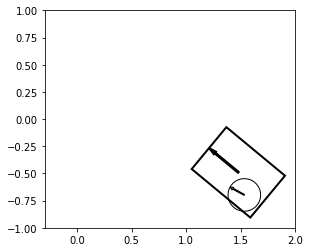

In [17]:
# Define some helper functions for animation and plotting
def draw_robot_patches(state, ax):
    """Adds patches for visualizing the robot to the given axes
    
    args:
        state: (x, y, theta_body, theta_spool, vx, vy, omega_body, omega_spool)
        ax: matplotlib axes
    returns:
        a list of properly transformed and colored patches for the box
    """
    # Dimensions
    width = 0.7
    height = 0.5
    spool_radius = 0.15
    com = jnp.array([width / 2.0, height / 2.0])
    
    robot_patches = []
    
    # Extract state
    robot_xy = state[:2]
    robot_theta = state[2]
    spool_offset = jnp.array([-width / 4.0, height / 4.0])
    spool_theta = state[3]
    
    # Make the transforms required to plot the various patches
    world_to_robot = transforms.Affine2D()
    world_to_robot = world_to_robot.rotate_around(*com, theta=robot_theta)
    world_to_robot = world_to_robot.translate(*(robot_xy - com))
    
    robot_to_arrow = transforms.Affine2D()
    robot_to_arrow = robot_to_arrow.rotate_around(0.0, 0.0, theta=-jnp.pi / 2)
    robot_to_arrow = robot_to_arrow.translate(*com)
    world_to_arrow = robot_to_arrow + world_to_robot
    
    robot_to_spool = transforms.Affine2D()
    robot_to_spool = robot_to_spool.rotate_around(0, 0, theta=spool_theta)
    robot_to_spool = robot_to_spool.translate(*spool_offset)
    robot_to_spool = robot_to_spool.rotate_around(0, 0, theta=robot_theta)
    robot_to_spool = robot_to_spool.translate(*robot_xy)
    world_to_spool = robot_to_spool + world_to_robot
    
    robot_body = patches.Rectangle(
        (0, 0),
        width,
        height,
        linewidth=2,
        transform=world_to_robot + ax.transData,
        edgecolor="k",
        fill=False,
    )
    robot_patches.append(robot_body)
    
    # Add an arrow along the extrusion axis
    arrow = patches.Arrow(
        0,
        0,
        0,
        width / 2,
        width=height / 10,
        linewidth=2,
        transform=world_to_arrow + ax.transData,
        edgecolor="k",
        fill=True,
    )
    robot_patches.append(arrow)
    
    # Add the spool
    spool = patches.Circle(
        (0, 0),
        spool_radius,
        linewidth=1,
        transform=robot_to_spool + ax.transData,
        edgecolor="k",
        fill=False,
    )
    robot_patches.append(spool)
    spool_arrow = patches.Arrow(
        0,
        0,
        0,
        spool_radius,
        width=height / 10,
        linewidth=1,
        transform=robot_to_spool + ax.transData,
        edgecolor="k",
        fill=True,
    )
    robot_patches.append(spool_arrow)
    
    for patch in robot_patches:
        ax.add_patch(patch)
    
    return robot_patches

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# initialization function: plot the background of each frame
def init():
    ax.clear()
    ax.set_xlim((-0.3, 2))
    ax.set_ylim((-1, 1))
    ax.set_aspect('equal')
    state = jnp.array([0.0, 0.0, 0.0, 0.0])
    patches = draw_robot_patches(state, ax)
    return patches

# animation function. This is called sequentially
def animate(i):
    ax.clear()
    ax.set_xlim((-0.3, 2))
    ax.set_ylim((-1, 1))
    ax.set_aspect('equal')
    state = jnp.array([0.5 + 0.02 * i, -0.01 * i, 1 * i / 20, 2 * i / 20])
    patches = draw_robot_patches(state, ax)
    return patches

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=40, blit=True)

anim

# Modeling the dynamics of a free-floating bendformer

Let's model the bendformer with 3 components (we'll start in the 2D case for now).

1. The robot body, which has mass $m_b$ and inertia $I_b$
2. The spool, which has mass $m_s$ and inertia $I_s$
3. The extruded wire structure, which has mass $m_w$ and shape $I_w$. We'll assume that the wire structure is rigid (to simplify things).

Let's model this system with first-order (velocity-only) dynamics, and we'll start by treating each of these components as separate rigid bodies. We'll then define additional constraints based on the kinematics of the system (i.e. what's connected to what), then derive the dynamics by enforcing conservation of linear and angular momentum.

If we treat each component as a rigid body, we get 3 positional degrees of freedom (DoF) and 3 velocity DoFs for each component:
- Body: position $(x_b, y_b, \theta_b)$ and velocities $(v_{xb}, v_{yb}, \omega_{yb})$.
- Spool: position $(x_s, y_s, \theta_s)$ and velocities $(v_{xs}, v_{ys}, \omega_{ys})$.
- Wire: position $(x_w, y_w, \theta_w)$ and velocities $(v_{xw}, v_{yw}, \omega_{yw})$.

The kinematic constraints are:
1. The spool is attached to the body by a revolute joint, so $\theta_s - \theta_b$ can vary but the position of the spool in the body frame is fixed.
2. The wire structure is extruded from the robot and can be bent. During extrusion, the linear velocity of the wire in the body frame must be solely in the $x$ direction; during bending, the center-of-mass of the wire must trace a circular arc in the body frame around the bend point.
3. The extruded wire starts out wrapped around the spool, so the extrusion velocity of the wire must match the linear velocity of the edge of the spool.

Let's introduce *monogram notation* for the rigid body positions and velocities. Let `X_WB` = $X_W^B$ denote the pose (linear and angular position) of the body frame $B$ expressed in the world frame $W$, and likewise for the spool frame $S$ and wire frame $Wire$. Spatial velocities (linear and angular) are similarly denoted as `V_WB` = $V_W^B$ and so on. Poses are synonymous with transformations between frames, so if `X_BS` is the pose of the spool in the body frame, then `X_WS = X_WB * X_BS` is given by composing these two transformations. See [here](https://manipulation.csail.mit.edu/pick.html#section2) for more details.

The constraints listed above can be expressed formally as follows:

#### 1. Spool is attached to the body frame by a revolute joint

We can define a single variable $\theta_{bs}$ to denote the relative angle between the body and the spool, which defines the body-to-spool transformation $X_B^S$ as a constant translation plus a rotation of $\theta_bs$ around the body $z$ axis.

#### 2.a During extrusion, the velocity of the wire's center of mass is solely in the body's x direction

This implies that the $v_y$ and $\omega$ components of $V_B^{Wire}$ are zero

#### 2.b During bending, the wire's center of mass must trace a 